# COMP 204 Lecture 27
# Sequence Analysis with BioPython
## Yue Li
#### based on materials from Mathieu Blanchette

Edit directly on the notebook

In [60]:
x=2
print(x)
print("Hello world")

2
Hello world


# BioPython

BioPython is a very popular third party Python package for handling biological data.

In order to install:

```
conda install biopython
```

BioPython has three major functionalities:

* Sequence Handling
* 3D Structure
* Population Genetics

Today we'll cover sequence handling and next time we will do 3D structure handling, and if there is time we may do some Population Genetics.

Some useful references: [tutorial](http://biopython.org/DIST/docs/tutorial/Tutorial.html), [website](http://biopython.org/), [wiki](http://biopython.org/wiki/Category%3AWiki_Documentation) (most of my examples are coming from these sources).
 
# `BioPython.Seq`

The main object we'll be dealing with are sequences. This is handled by the `Seq` class.

As we know, we can have DNA, RNA, and Protein sequences.

BioPython helps us cleanly distinguish and do different things with different kinds of sequences.

In [61]:
#let's make a generic sequence

from Bio.Seq import Seq # Seq is a class defined in Bio.Seq file

my_seq = Seq("CCCGGAGAGA")
print(type(my_seq))
#let's see what attributes this object has
print(my_seq)

<class 'Bio.Seq.Seq'>
CCCGGAGAGA


It seems like there is a lot we can do with this object.

The problem is at this point Python doesn't know what kind of sequence this is (DNA, RNA, Protein).

We have to specify what kind of "Alphabet" the sequence belongs to.

In [62]:
#right now it has just a generic alphabet
print(my_seq.alphabet)

Alphabet()


In [63]:
from Bio.Alphabet import generic_dna, generic_protein, generic_rna

my_dna = Seq("CCCGGAGAG", generic_dna)
my_rna = Seq("ACCCGUUGU", generic_rna)
my_protein = Seq("AKKKGGGUUULL", generic_protein)

print(my_dna.alphabet)
print(my_rna.alphabet)
print(my_protein.alphabet)

DNAAlphabet()
RNAAlphabet()
ProteinAlphabet()


Biopython will now know the difference for example between a DNA base `A` for adenine and the protein residue `A` for alanine.

Now we can do some cool things.

We can perform the main actions of the central dogma: transcribe and translate.

In [64]:
my_gene = Seq("ATGGCCATTGTAATGGGCCGCTGAAAGGGTGCCCGATAG", generic_dna)

#get the mRNA

my_transcript = my_gene.transcribe()
print(my_transcript)

#get the protein from the mRNA
my_protein = my_transcript.translate()
print(my_protein)

AUGGCCAUUGUAAUGGGCCGCUGAAAGGGUGCCCGAUAG
MAIVMGR*KGAR*


As you can see, we got some STOP codons represented as `*` and translation continued.

We can get translation to actually stop when it encounters a STOP codon.

In [65]:
myprot = my_transcript.translate(to_stop=True)
print(myprot)

MAIVMGR


### General sequence methods

There are some convenient operations for dealing with sequences.

We can concatenate sequences if they are of matching type.

In [66]:
seq1 = Seq("AAACGGA", generic_dna)
seq2 = Seq("GGAGAT", generic_dna)

print(seq1 + seq2)

AAACGGAGGAGAT


We can also index and slice as though we had strings.

In [67]:
print(seq1[:2] + seq2[-1])

AAT


`Seq` objects are immutable, just like strings.

In [68]:
seq1[2] = "G"

TypeError: 'Seq' object does not support item assignment

There is another type of object called a `MutableSeq`. If we want to support mutability we can convert a `Seq` object to a `MutableSeq` object quite easily.

In [69]:
mut_seq = seq1.tomutable()
mut_seq

MutableSeq('AAACGGA', DNAAlphabet())

In [70]:
mut_seq[0] = "G"
print(mut_seq)

GAACGGA


We can also do searching inside sequences.

In [71]:
myseq = Seq("CCAGAAACCCGGAA", generic_dna)

#find the first occurence of the pattern
print(myseq.find("GAA"))

#find the number of non-overlapping occurrences of a pattern
print(myseq.count("GAA"))

3
2


# Sequence alignment

Say you isolated some piece of DNA in the lab and obtained its sequence.

You now want to find out which organism that sequence belongs to.

You ask a biologist and they tell you to just "BLAST it". (recalled Lecture 14 miniBlast program)

As you may know already, this is essentially the same as "Google it" for biologists.

BLAST is an alignment algorithm that searches for your sequence of interest in a huge database of sequences whose origins are known.

If you didn't know BioPython, you would take your sequence `CTCTCCCAGCTGAGCTATAGCCCCAATGCGCACATAATAAATCGTGTGAACGGGGCGCATGATATGAGAC` 
and go to the [NCBI BLAST web server](https://blast.ncbi.nlm.nih.gov/Blast.cgi?PROGRAM=blastn&PAGE_TYPE=BlastSearch&LINK_LOC=blasthome) and click on buttons like a monkey.

Thanks to BioPython we can do this programatically!

The `qblast` ('q' stands for query) method from the `Bio.Blast.NCBIWWW` module essentially sends our sequence to the BLAST web server.

Here we are using the "nucleotice BLAST" algorithm so we say `blastn` and we are using it on the database of all nucleotide sequences, called `nt`.


In [72]:
from Bio.Blast import NCBIWWW
s = Seq("CTCTCCCAGCTGAGCTATAGCCCCAATGCGCACATAATAAATCGTGTGAACGGGGCGCATGATATGAGAC", generic_dna)
result_handle = NCBIWWW.qblast("blastn", "nt", s)

We wait a few seconds and get a `result_handle` which is like a temporary open file that we can read from.

The format of this file is in XML so not easy to read, thankfully BioPython has an XML parser that extracts all the information for us.

In [73]:
from Bio.Blast import NCBIXML
blast_records = NCBIXML.parse(result_handle)

We get an "iterator" of BLAST record objects, or "search results". We can now loop over each of our search results and print some information.

Here I am looping over all the results which each have an attribute `alignments` which are the alignments of our query sequence to some organism in the database.

The `alignment` attribute itself has other attributes like the `query` sequence, the `length` and `title` of the matching organism..

In [74]:
for b in blast_records:
    for alignment in b.alignments:
        for hsp in alignment.hsps:
            print('****Alignment****')
            print('sequence:', alignment.title)
            print('length:', alignment.length)
            print('e value:', hsp.expect)
            print(hsp.query[0:75] + '...')
            print(hsp.match[0:75] + '...')
            print(hsp.sbjct[0:75] + '...')

****Alignment****
sequence: gi|1539444317|emb|LR134163.1| Yersinia pseudotuberculosis strain NCTC10217 genome assembly, chromosome: 1
length: 4687913
e value: 2.92906e-26
CTCTCCCAGCTGAGCTATAGCCCCAATGCGCACATAATAAATCGTGTGAACGGGGCGCATGATATGAGAC...
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||...
CTCTCCCAGCTGAGCTATAGCCCCAATGCGCACATAATAAATCGTGTGAACGGGGCGCATGATATGAGAC...
****Alignment****
sequence: gi|1539444317|emb|LR134163.1| Yersinia pseudotuberculosis strain NCTC10217 genome assembly, chromosome: 1
length: 4687913
e value: 0.0786671
CTCTCCCAGCTGAGCTATAGCCCCA...
|||||||||||||||||||||||||...
CTCTCCCAGCTGAGCTATAGCCCCA...
****Alignment****
sequence: gi|1539444317|emb|LR134163.1| Yersinia pseudotuberculosis strain NCTC10217 genome assembly, chromosome: 1
length: 4687913
e value: 0.0786671
CTCTCCCAGCTGAGCTATAGCCCCA...
|||||||||||||||||||||||||...
CTCTCCCAGCTGAGCTATAGCCCCA...
****Alignment****
sequence: gi|1539444317|emb|LR134163.1| Yersinia pseudotuberculosis strain NC

CTCTCCCAGCTGAGCTATAGCCCCA...
|||||||||||||||||||||||||...
CTCTCCCAGCTGAGCTATAGCCCCA...
****Alignment****
sequence: gi|755363594|gb|CP009715.1| Yersinia pestis Pestoides F, complete genome
length: 4519828
e value: 0.0786671
CTCTCCCAGCTGAGCTATAGCCCCA...
|||||||||||||||||||||||||...
CTCTCCCAGCTGAGCTATAGCCCCA...
****Alignment****
sequence: gi|755363594|gb|CP009715.1| Yersinia pestis Pestoides F, complete genome
length: 4519828
e value: 0.958361
AATCGTGTGAACGGGGCGCATGATAT...
||||||||||||||||||||| ||||...
AATCGTGTGAACGGGGCGCATCATAT...
****Alignment****
sequence: gi|755359298|gb|CP009712.1| Yersinia pseudotuberculosis IP 32953, complete genome
length: 4743972
e value: 2.92906e-26
CTCTCCCAGCTGAGCTATAGCCCCAATGCGCACATAATAAATCGTGTGAACGGGGCGCATGATATGAGAC...
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||...
CTCTCCCAGCTGAGCTATAGCCCCAATGCGCACATAATAAATCGTGTGAACGGGGCGCATGATATGAGAC...
****Alignment****
sequence: gi|755359298|gb|CP009712.1| Yersinia pseudotuberculosis IP 32953, co

# `SeqRecord` and `SeqIO`

Often, sequences have some additional information associated to them. 

A good example was the BLAST exercise which gave us sequences associated to specific organisms, and genomic locations.

Ideally we would want to be able to keep this information along with our `Seq` if we have it.

BioPython lets us do this with the `SeqRecord` and `SeqIO` classes.


## Parsing with `SeqIO`

The `SeqIO` class which stands for Sequence Input/Output lets us read and write from various sequence annotation file formats which are common in biological databases.

I went to the [GenBank](https://www.ncbi.nlm.nih.gov/genbank/) sequence database and looked for some sequence related to the Bubonic Plague (Yersinia Pestis bacteria) [here](https://www.ncbi.nlm.nih.gov/nuccore/NZ_ADRZ01000932.1?report=fasta).



We get a `fasta` file which is very common for sequence annotations so BioPython can parse it for us automatically.

The annotation for a FASTA sequence is typically held in the header:

```
>NZ_ADRZ01000932.1 Yersinia pestis biovar Antiqua str. E1979001 Contig_E1979001_19275, whole genome shotgun sequence
```

The `SeqIO.parse` takes a path to a file and a format, in this case "fasta" and produces an iteratror over each entry in the fasta file.

Each item produced by the iterator is a `SeqRecords` object.


In [75]:
from Bio import SeqIO

record = SeqIO.read("plague.fa", "fasta")
print(record)

ID: NZ_ADRZ01000932.1
Name: NZ_ADRZ01000932.1
Description: NZ_ADRZ01000932.1 Yersinia pestis biovar Antiqua str. E1979001 Contig_E1979001_19275, whole genome shotgun sequence
Number of features: 0
Seq('CTCTCCCAGCTGAGCTATAGCCCCAATGCGCACATAATAAATCGTGTGAACGGG...AGC', SingleLetterAlphabet())


The `SeqRecords` object has some useful attributes.

The object contains a `Seq` object witih the sequence info.

In [76]:
print(record.seq)

CTCTCCCAGCTGAGCTATAGCCCCAATGCGCACATAATAAATCGTGTGAACGGGGCGCATGATATGAGACCCCCGAAACTGTGTCAACGGCTAAATCGATTTCTCGTGTTAAGCGCTGAAAAAGCGGCCAAATCAGCCTGCAAATAACATAATAAGTGGAATGATGTTCACAAATTTGTTGTCACACCGCTGCTGTTATCAAATATAATAAATATCCTCCGGCATAGC


In [77]:
print(record)

ID: NZ_ADRZ01000932.1
Name: NZ_ADRZ01000932.1
Description: NZ_ADRZ01000932.1 Yersinia pestis biovar Antiqua str. E1979001 Contig_E1979001_19275, whole genome shotgun sequence
Number of features: 0
Seq('CTCTCCCAGCTGAGCTATAGCCCCAATGCGCACATAATAAATCGTGTGAACGGG...AGC', SingleLetterAlphabet())


In [78]:
print(record.id)

NZ_ADRZ01000932.1


In [79]:
print(record.description)

NZ_ADRZ01000932.1 Yersinia pestis biovar Antiqua str. E1979001 Contig_E1979001_19275, whole genome shotgun sequence


We can also create our own `SeqRecord` objects.

In [80]:
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Alphabet import IUPAC
record = SeqRecord(Seq("MKQHKAMIVALIVICITAVVAALVTRKDLCEVHIRTGQTEVAVF",
                       IUPAC.protein),
                   id="YP_025292.1", name="HokC",
                   description="toxic membrane protein, small")
print(record)

ID: YP_025292.1
Name: HokC
Description: toxic membrane protein, small
Number of features: 0
Seq('MKQHKAMIVALIVICITAVVAALVTRKDLCEVHIRTGQTEVAVF', IUPACProtein())


Then we can write it to FASTA format.

In [81]:
record.format("fasta")

'>YP_025292.1 toxic membrane protein, small\nMKQHKAMIVALIVICITAVVAALVTRKDLCEVHIRTGQTEVAVF\n'

And then store it in a file. 

So now we know how to read sequence information, as well as produce our own sequence records and store them.

In [82]:
f = open("myfasta.fa", "w")
f.write(record.format("fasta"))
f.close()    

## Making Multiple Sequence Alignments and Phylogenetic Trees

Another thing biologists like to do is align (essentially, compare) sequences.

We have seen multiple sequence alignment problem in our Assignment 2.

Basically, we first align any pair of sequences and evaluate how they differ from each other based on the similarity score (i.e., similarity score = match scores + gap penalties + mismatch panalties).

The similarity scores imply sequence phylogeny. 

We first compute a tree derived from the similarity between species in terms of their given sequences).

We then predict how evolution took place to explain a particular set of observed sequences.



### Step 1: Obtain some sequences and align them

Use the fasta file p53.fa found here: https://www.cs.mcgill.ca/~yueli/teaching/COMP204_Winter2019/Lectures/27/p53.fa
and use the ClustalW tool https://www.ebi.ac.uk/Tools/msa/clustalw2/
to produce a multiple sequence alignment. The result is here: https://www.cs.mcgill.ca/~yueli/teaching/COMP204_Winter2019/Lectures/27/p53.aln

First install ClustalW by the following commandline in the Anaconda Prompt

```
conda install -c bioconda clustalw
```


### Step 2: Align the sequences

In [83]:
from Bio.Align.Applications import ClustalwCommandline
in_file = "p53.fa"
out_file = "p53.aln"
cline = ClustalwCommandline("clustalw", infile=in_file, outfile=out_file)
stdout, stderr = cline()
print(stdout)




 CLUSTAL 2.1 Multiple Sequence Alignments


Sequence format is Pearson
Sequence 1: human         70 bp
Sequence 2: baboon        70 bp
Sequence 3: mouse         70 bp
Sequence 4: rat           70 bp
Sequence 5: cow           70 bp
Sequence 6: cat           67 bp
Sequence 7: dog           67 bp
Start of Pairwise alignments
Aligning...

Sequences (1:2) Aligned. Score:  98
Sequences (1:3) Aligned. Score:  78
Sequences (1:4) Aligned. Score:  77
Sequences (1:5) Aligned. Score:  85
Sequences (1:6) Aligned. Score:  82
Sequences (1:7) Aligned. Score:  86
Sequences (2:3) Aligned. Score:  77
Sequences (2:4) Aligned. Score:  75
Sequences (2:5) Aligned. Score:  84
Sequences (2:6) Aligned. Score:  80
Sequences (2:7) Aligned. Score:  85
Sequences (3:4) Aligned. Score:  90
Sequences (3:5) Aligned. Score:  74
Sequences (3:6) Aligned. Score:  76
Sequences (3:7) Aligned. Score:  80
Sequences (4:5) Aligned. Score:  65
Sequences (4:6) Aligned. Score:  74
Sequences (4:7) Aligned. Score:  77
Sequences (5

Now that we have `SeqRecord` objects we can align them.

To do so, we need to put them in a `fasta` file.

### Step 3: Load the resulting alignment

In [84]:
#open the alignmnent file
from Bio import AlignIO
aln = open("p53.aln", "r") #use AlignIO to read the alignment file in 'clustal' format
alignment = AlignIO.read(aln, "clustal")

print(alignment)

SingleLetterAlphabet() alignment with 7 rows and 70 columns
CTCATAGGGCACCACCACACTATGTCGAAAAGTGTTTCTGTCAT...CCT human
CTCATAGGGCACCACCACACTATGTCGAAAAGTGTTTCTGTCAT...CCT baboon
CTCATAGGGCACCACCACACTGTGTCTAAAGGTGTTCCGGTCGT...CCT cow
CTCGTAGGGCACCACGACGCTATGTCGGA---TGTTTCTGTCGT...CCT cat
CTCATAAGGCACCACCACACTGTGTCGAA---TGTTTCTGTCGT...CCT dog
CTCATAAGGTACCACCACGCTGTGGCGAAAAGTCTGCCTGTCTT...CCT mouse
CTCATACGGTACCACCACGCTGTGCCGAAAAGTCTGCCTGTCGT...CCT rat


In [85]:
#write our sequences to fasta format
with open("seqs.fasta", "w") as f:
    SeqIO.write(seq_records, f, "fasta")

We can parse the alignment with the `AlignIO` module from BioPython.

I won't go into detail on this module but it has a lot of useful funcionality for dealing with sequence alignments.


### Step 4: Use the alignment to obtain a "distance" between all pairs of sequences

Using the parsed alignment, we can get the distance (or difference) between all the sequences.

This just tells us, for each pair of sequences, how different they are.

In [86]:
from Bio.Phylo.TreeConstruction import DistanceCalculator

#calculate the distance matrix
calculator = DistanceCalculator('identity')
#adds distance matrix to the calculator object and returns it
dm = calculator.get_distance(alignment)
print(dm)

human	0
baboon	0.014285714285714235	0
cow	0.1428571428571429	0.15714285714285714	0
cat	0.2142857142857143	0.22857142857142854	0.2857142857142857	0
dog	0.17142857142857137	0.18571428571428572	0.19999999999999996	0.12857142857142856	0
mouse	0.2142857142857143	0.22857142857142854	0.2571428571428571	0.27142857142857146	0.22857142857142854	0
rat	0.22857142857142854	0.24285714285714288	0.2571428571428571	0.2857142857142857	0.2571428571428571	0.09999999999999998	0
	human	baboon	cow	cat	dog	mouse	rat


### Step 5: Construct a tree from the set of distances

And finally, we can construct a phylogenetic tree from the pairwise distances between all the sequences.

In [87]:
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor

#initialize a DistanceTreeConstructor object based on our distance calculator object
constructor = DistanceTreeConstructor(calculator)

#build the tree
upgma_tree = constructor.build_tree(alignment)

And let's use the `Phylo` module to visualize the result!

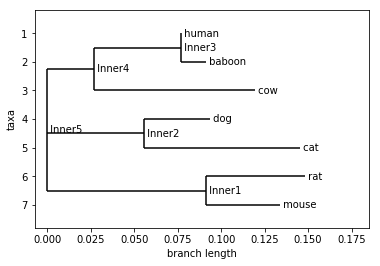

In [88]:
from Bio import Phylo
import pylab
#draw the tree
Phylo.draw(upgma_tree)